![alt text](reports/Figures/Lumbar.jpg)

## **Lumbar Coordinate**
#### **About dataset**

This dataset was put together as a pretraining objective for the RSNA 2024 Lumbar Spine Degenerative Classification competition. The dataset consists of various medical images of the lower lumbar spine (external data). Each image is given 5 key points that correspond to the 5 lower lumbar vertebrae.

Additionally, we include improved coordinates for the RSNA 2024 data. Here we add coordinates for the left side of each lumbar disc in the sagittal plane. This provides useful orientation information for each disc.

**Changelog**
- V1. Added external coordinate data
- V2. Added improved RSNA coordinates

In [1]:
# librery

import os
import glob
import random
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from types import SimpleNamespace
import cv2
import albumentations as A
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import pydicom

In [2]:
def convert_to_8bit(x):
    lower, upper = np.percentile(x, (1, 99))
    x = np.clip(x, lower, upper)
    x = x - np.min(x)
    x = x / np.max(x)
    return (x * 255).astype("uint8")

In [3]:
def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

In [ ]:
# Config
cfg = SimpleNamespace(
    img_dir=r"C:\Users\Carlo\Desktop\Proyectos\Lumbar\data\Processed",
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    n_frames=3,
    epochs=10,
    lr=0.0005,
    batch_size=16,
    backbone="resnet18",
    seed=0,
)
set_seed(seed=cfg.seed)  # Makes results reproducable

In [ ]:
# Load metadata
df = pd.read_csv(
    r"C:\Users\Carlo\Desktop\Proyectos\Lumbar\data\csv\coords_pretrain.csv"
)
df = df.sort_values(["source", "filename", "level"]).reset_index(drop=True)
df["filename"] = df["filename"].str.replace(".jpg", ".npy")
df["series_id"] = df["source"] + "_" + df["filename"].str.split(".").str[0]

print("----- IMGS per source -----")
display((df.source.value_counts() / 5).astype(int).reset_index())

----- IMGS per source -----


,source,count
0,lsd,504
1,tseg,375
2,spider,209
3,osf,33


In [ ]:
class PreTrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, cfg):
        self.cfg = cfg
        self.records = self.load_coords(df)

    def load_coords(self, df):
        # Convert to dict
        d = df.groupby("series_id")[["relative_x", "relative_y"]].apply(
            lambda x: list(x.itertuples(index=False, name=None))
        )
        records = {}
        for i, (k, v) in enumerate(d.items()):
            records[i] = {"series_id": k, "label": np.array(v).flatten()}
            assert len(v) == 5

        return records

    def pad_image(self, img):
        n = img.shape[-1]
        if n >= self.cfg.n_frames:
            start_idx = (n - self.cfg.n_frames) // 2
            return img[:, :, start_idx : start_idx + self.cfg.n_frames]
        else:
            pad_left = (self.cfg.n_frames - n) // 2
            pad_right = self.cfg.n_frames - n - pad_left
            return np.pad(
                img,
                ((0, 0), (0, 0), (pad_left, pad_right)),
                "constant",
                constant_values=0,
            )

    def load_img(self, source, series_id):
        fname = os.path.join(
            self.cfg.img_dir, "processed_{}/{}.npy".format(source, series_id)
        )
        img = np.load(fname).astype(np.float32)
        img = self.pad_image(img)
        img = np.transpose(img, (2, 0, 1))
        img = img / 255.0
        return img

    def __getitem__(self, idx):
        d = self.records[idx]
        label = d["label"]
        source = d["series_id"].split("_")[0]
        series_id = "_".join(d["series_id"].split("_")[1:])

        img = self.load_img(source, series_id)
        return {
            "img": img,
            "label": label,
        }

    def __len__(
        self,
    ):
        return len(self.records)


ds = PreTrainDataset(df, cfg=cfg)

# Plot a Single Sample
print("---- Sample Shapes -----")
for k, v in ds[0].items():
    print(k, v.shape)

---- Sample Shapes -----
img (3, 256, 256)
label (10,)


In [ ]:
def batch_to_device(batch, device, skip_keys=[]):
    batch_dict = {}
    for key in batch:
        if key in skip_keys:
            batch_dict[key] = batch[key]
        else:
            batch_dict[key] = batch[key].to(device)
    return batch_dict


def visualize_prediction(batch, pred, epoch):

    mid = cfg.n_frames // 2

    # Plot
    for idx in range(1):

        # Select Data
        img = batch["img"][idx, mid, :, :].cpu().numpy() * 255
        cs_true = batch["label"][idx, ...].cpu().numpy() * 256
        cs = pred[idx, ...].cpu().numpy() * 256

        coords_list = [("TRUE", "lightblue", cs_true), ("PRED", "orange", cs)]
        text_labels = [str(x) for x in range(1, 6)]

        # Plot coords
        fig, axes = plt.subplots(1, len(coords_list), figsize=(10, 4))
        fig.suptitle("EPOCH: {}".format(epoch))
        for ax, (title, color, coords) in zip(axes, coords_list):
            ax.imshow(img, cmap="gray")
            ax.scatter(coords[0::2], coords[1::2], c=color, s=50)
            ax.axis("off")
            ax.set_title(title)

            # Add text labels near the coordinates
            for i, (x, y) in enumerate(zip(coords[0::2], coords[1::2])):
                if i < len(text_labels):  # Ensure there are enough labels
                    ax.text(
                        x + 10,
                        y,
                        text_labels[i],
                        color="white",
                        fontsize=15,
                        bbox=dict(facecolor="black", alpha=0.5),
                    )

        fig.suptitle("EPOCH: {}".format(epoch))
        plt.show()
    #         plt.close(fig)
    return


def load_weights_skip_mismatch(model, weights_path, device):
    # Load Weights
    state_dict = torch.load(weights_path, map_location=device)
    model_dict = model.state_dict()

    # Iter models
    params = {}
    for (sdk, sfv), (mdk, mdv) in zip(state_dict.items(), model_dict.items()):
        if sfv.size() == mdv.size():
            params[sdk] = sfv
        else:
            print("Skipping param: {}, {} != {}".format(sdk, sfv.size(), mdv.size()))

    # Reload + Skip
    model.load_state_dict(params, strict=False)
    print("Loaded weights from:", weights_path)

In [ ]:
# Dataframes
train_df = df[df["source"] != "spider"]
val_df = df[df["source"] == "spider"]
print("TRAIN_SIZE: {}, VAL_SIZE: {}".format(len(train_df) // 5, len(val_df) // 5))

# Datasets + Dataloaders
train_ds = PreTrainDataset(train_df, cfg)
val_ds = PreTrainDataset(val_df, cfg)
print(df)
train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=cfg.batch_size, shuffle=True, drop_last=True
)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False)

# Model
model = timm.create_model("resnet18", pretrained=True, num_classes=10)
model = model.to(cfg.device)

# Loss / Optim
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr)

TRAIN_SIZE: 912, VAL_SIZE: 209
           filename source    x    y  level  relative_x  relative_y  \
0          0001.npy    lsd  101   77  L1/L2    0.394531    0.300781   
1          0001.npy    lsd   92  106  L2/L3    0.359375    0.414062   
2          0001.npy    lsd   89  138  L3/L4    0.347656    0.539062   
3          0001.npy    lsd   88  166  L4/L5    0.343750    0.648438   
4          0001.npy    lsd   91  189  L5/S1    0.355469    0.738281   
...             ...    ...  ...  ...    ...         ...         ...   
5600  case_1224.npy   tseg  126  103  L1/L2    0.492188    0.402344   
5601  case_1224.npy   tseg  121  128  L2/L3    0.472656    0.500000   
5602  case_1224.npy   tseg  117  150  L3/L4    0.457031    0.585938   
5603  case_1224.npy   tseg  119  173  L4/L5    0.464844    0.675781   
5604  case_1224.npy   tseg  130  195  L5/S1    0.507812    0.761719   

           series_id  
0           lsd_0001  
1           lsd_0001  
2           lsd_0001  
3           lsd_0001  
4

100%|██████████| 14/14 [00:06<00:00,  2.07it/s]


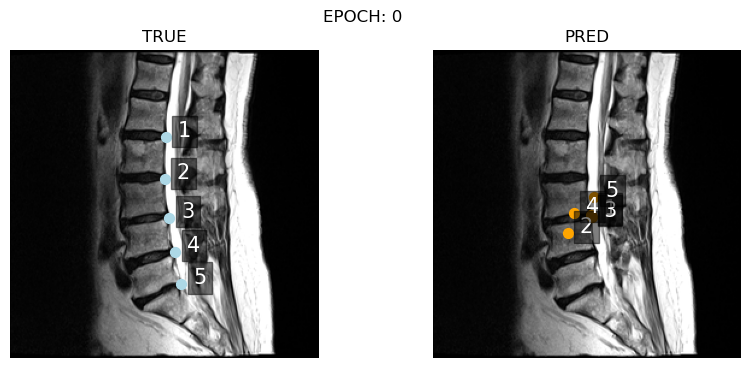

Epoch 1, Training Loss: 0.0, Validation Loss: 0.02208872019712414


100%|██████████| 14/14 [00:02<00:00,  6.25it/s]


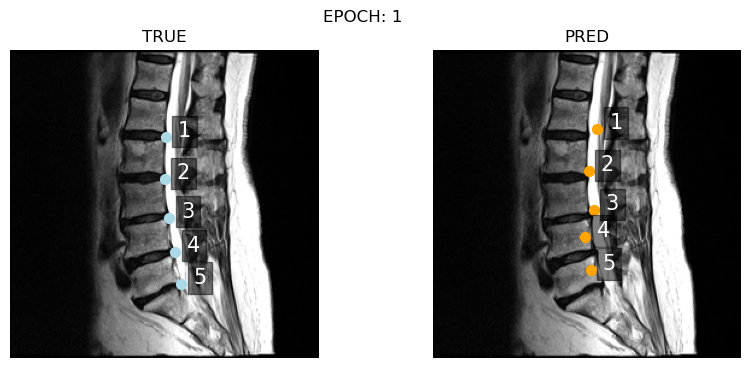

Epoch 2, Training Loss: 0.00077527278335765, Validation Loss: 0.0038934535363556017


100%|██████████| 14/14 [00:02<00:00,  5.93it/s]


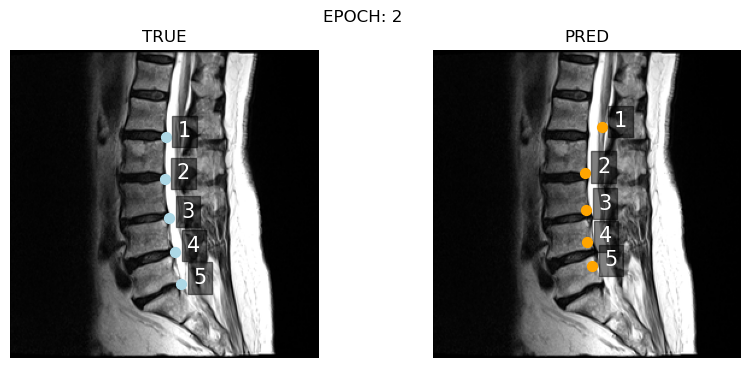

Epoch 3, Training Loss: 0.0013168839504942298, Validation Loss: 0.0033387161591755493


100%|██████████| 14/14 [00:02<00:00,  6.03it/s]


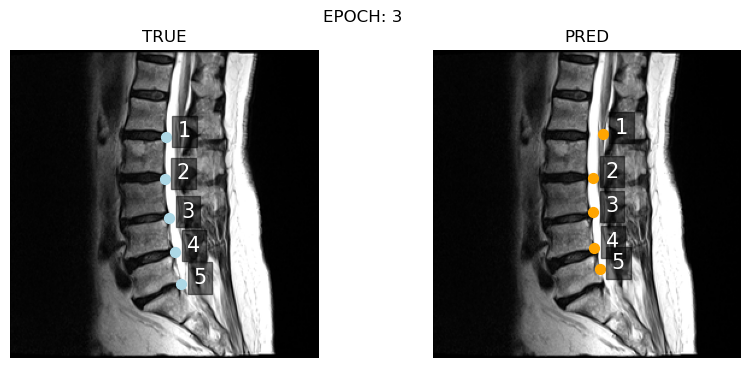

Epoch 4, Training Loss: 0.0006424115272238851, Validation Loss: 0.0029122531788224088


100%|██████████| 14/14 [00:02<00:00,  5.73it/s]


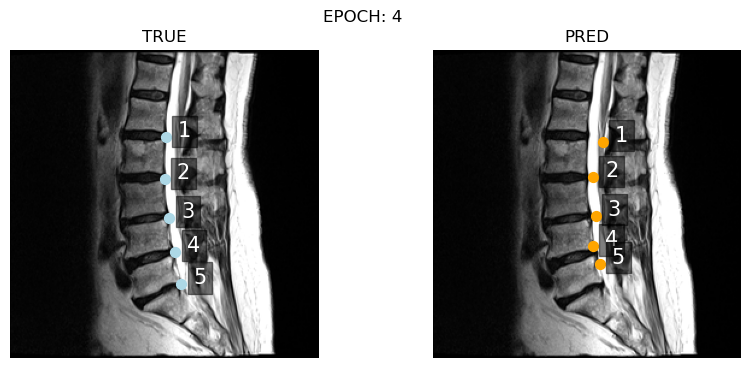

Epoch 5, Training Loss: 0.0003085862554144114, Validation Loss: 0.00278343226610949


100%|██████████| 14/14 [00:02<00:00,  6.37it/s]


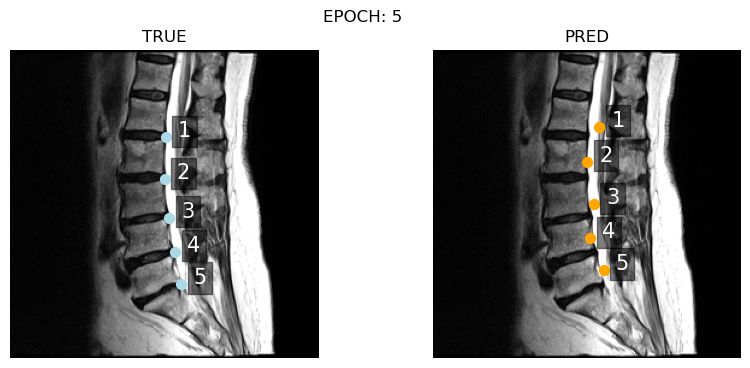

Epoch 6, Training Loss: 0.0002973678056150675, Validation Loss: 0.0026648250474993673


100%|██████████| 14/14 [00:02<00:00,  6.34it/s]


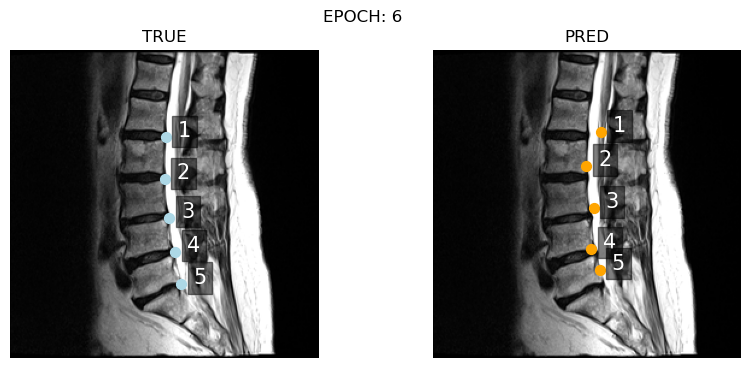

Epoch 7, Training Loss: 0.00028417151770554483, Validation Loss: 0.0027004083177806543


100%|██████████| 14/14 [00:02<00:00,  6.03it/s]


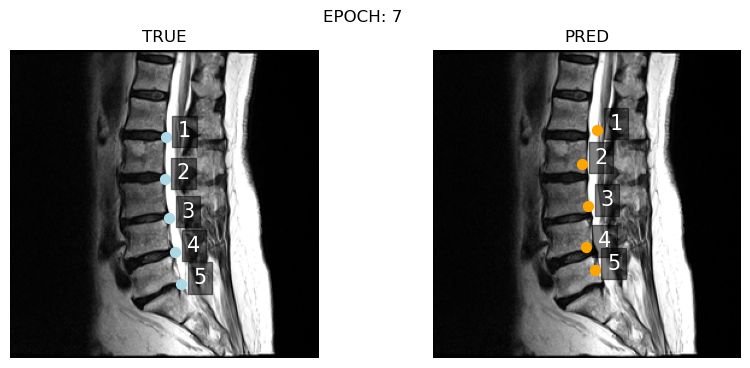

Epoch 8, Training Loss: 0.0004620725230779499, Validation Loss: 0.0032671744785537677


100%|██████████| 14/14 [00:02<00:00,  6.22it/s]


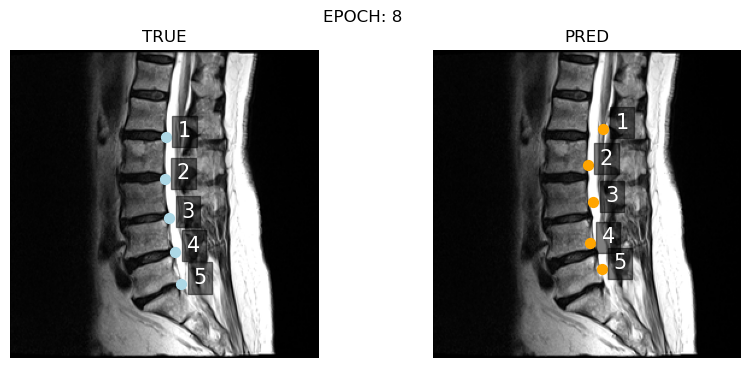

Epoch 9, Training Loss: 0.0005425148992799222, Validation Loss: 0.002603371053867574


100%|██████████| 14/14 [00:02<00:00,  5.98it/s]


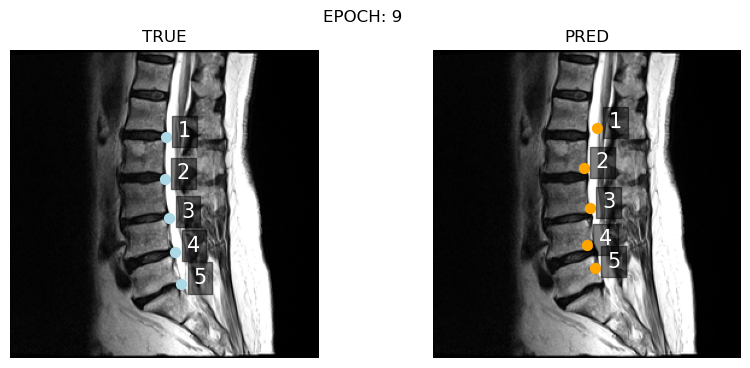

Epoch 10, Training Loss: 0.00020322785712778568, Validation Loss: 0.00271637797621744


100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


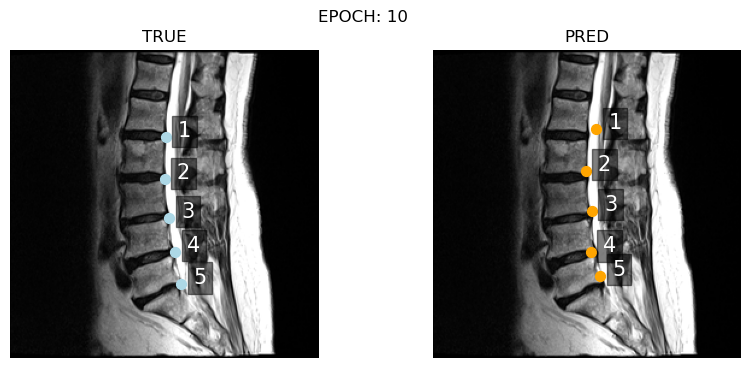

Epoch 11, Training Loss: 0.00014639340224675834, Validation Loss: 0.002642273052645448
Training complete...


In [ ]:
cfg.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(cfg.epochs + 1):

    # Train Loop
    loss = torch.tensor([0.0]).float().to(cfg.device)
    if epoch != 0:
        model = model.train()
        for batch in tqdm(train_dl):
            batch = batch_to_device(batch, cfg.device)
            optimizer.zero_grad()

            x_out = model(batch["img"].float())
            x_out = torch.sigmoid(x_out)

            loss = criterion(x_out, batch["label"].float())
            loss.backward()
            optimizer.step()

    # Validation Loop
    val_loss = 0
    with torch.no_grad():
        model = model.eval()
        for batch in tqdm(val_dl):
            batch = batch_to_device(batch, cfg.device)

            pred = model(batch["img"].float())
            pred = torch.sigmoid(pred)

            val_loss += criterion(pred, batch["label"].float()).item()
        val_loss /= len(val_dl)

    # Viz
    visualize_prediction(batch, pred, epoch)

    print(f"Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss}")
print("Training complete...")

In [ ]:
f = "{}_{}.pt".format(cfg.backbone, cfg.seed)
torch.save(model.state_dict(), f)
print("Saved weights: {}".format(f))

Saved weights: resnet18_0.pt


In [ ]:
# Load backbone for RSNA 2024 task
model = timm.create_model("resnet18", pretrained=True, num_classes=75)
model = model.to(cfg.device)
load_weights_skip_mismatch(model, f, cfg.device)

Skipping param: fc.weight, torch.Size([10, 512]) != torch.Size([75, 512])
Skipping param: fc.bias, torch.Size([10]) != torch.Size([75])
Loaded weights from: resnet18_0.pt
